In [6]:
#importing packages
import pandas as pd
import numpy as np
import datetime
import pickle
from datetime import datetime, timedelta

In [7]:
#loading dataframe
pickle_in=open('fireCleaned.pickle','rb')
df = pickle.load(pickle_in)

In [8]:
dfcleaned = df.drop(['API_End','API_Start','API_Time','LandmarkLocation', 'ODFProtectedAcres'],axis=1)

In [9]:
#dropping all columns that are not relevant
dfcleaned.drop(['ID','FireName','Rng','ModifiedDate','LO_Name'],axis=1,inplace=True)

In [10]:
#dropping blank values
dfcleaned.dropna(subset=['CauseByDesc','Control_DateTime','PrecipProb','PrecipInten'],inplace=True)

In [11]:
#adding a column for duration of fire
dfcleaned['FireDuration']= dfcleaned['Control_DateTime'] - dfcleaned['Ign_DateTime']

In [12]:
dfcleaned['Days']=[x.days for x in dfcleaned['FireDuration']]

In [13]:
dfcleaned = dfcleaned.drop(['Ign_DateTime','ReportDateAndTime','Control_DateTime','SpecificDesc','Cause_Comments','CreationDate', 'FireDuration'], axis=1)

In [14]:
#removing fires where timedelta (days) is less than zero
dfcleaned = dfcleaned[dfcleaned['Days']>=0]

In [15]:
#removing fires where timedelta (days) is greater than 100 days and fireacres is less than 1000
dfcleaned = dfcleaned[dfcleaned['Days']<=172]

In [16]:
dfcleaned.dropna(inplace=True)

In [134]:
#pickling file for future use
import pickle
p_o=open('cleaneddata.pickle','wb')
pickle.dump(dfcleaned, p_o)

In [22]:
#creating a function to remove features that are not necessary
def dfcleaner(df):
    df = df[['FireYear','Area','District','Unit','FireNumber','FiscalYear','Twn','Sec','Subdiv','Long_DD','Lat_DD','HumanOrLightning','CauseByDesc','GeneralDesc','FireTotalAcres','Temp','DewPoint','Humidity','Weather','PrecipProb','PrecipInten','Wind','Days']]
    df = df.dropna(subset=['CauseByDesc','PrecipProb','PrecipInten'])
    return df

In [23]:
#cleaning dataframe for modeling
dfcleaned= dfcleaner(dfcleaned)

In [24]:
#verify that features are correct for modeling
dfcleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12726 entries, 0 to 13440
Data columns (total 23 columns):
FireYear            12726 non-null int64
Area                12726 non-null object
District            12726 non-null int64
Unit                12726 non-null int64
FireNumber          12726 non-null int64
FiscalYear          12726 non-null int64
Twn                 12726 non-null object
Sec                 12726 non-null float64
Subdiv              12726 non-null object
Long_DD             12726 non-null float64
Lat_DD              12726 non-null float64
HumanOrLightning    12726 non-null object
CauseByDesc         12726 non-null object
GeneralDesc         12726 non-null object
FireTotalAcres      12726 non-null float64
Temp                12726 non-null float64
DewPoint            12726 non-null float64
Humidity            12726 non-null float64
Weather             12726 non-null object
PrecipProb          12726 non-null float64
PrecipInten         12726 non-null float64
Wind 

In [25]:
#Preparing data for modeling 
dfclean = pd.get_dummies(dfcleaned)  #creating dummy columns for categorical data
target = dfclean['FireTotalAcres']   #creating a dependent column for predictions
features = dfclean.drop('FireTotalAcres', axis=1) #creating a features dataframe by dropping the target

feature_list = list(features.columns) #saving feature names
features = np.array(features) 
target = np.array(target) #convert features and labels into arrays

In [26]:
#importing trian test split
from sklearn.model_selection import train_test_split

#splitting data
train_features,test_features,train_labels,test_labels = train_test_split(features,target,test_size=0.25,random_state=42)

In [27]:
print('Training Features Shape of full dataset:', train_features.shape)
print('Training Labels Shape of full dataset:', train_labels.shape)
print('Testing Features Shape of full dataset:', test_features.shape)
print('Testing Labels Shape of full dataset:', test_labels.shape)

Training Features Shape of full dataset: (9544, 172)
Training Labels Shape of full dataset: (9544,)
Testing Features Shape of full dataset: (3182, 172)
Testing Labels Shape of full dataset: (3182,)


In [28]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 100 decision trees
rf100 = RandomForestRegressor(n_estimators = 100, oob_score = True, random_state = 42)

# Train the model on training data
rf100.fit(train_features, train_labels.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [30]:
# Import the model we are using 
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf1000 = RandomForestRegressor(n_estimators = 1000, oob_score = True, random_state = 42)

# Train the model on training data
rf1000.fit(train_features, train_labels.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [32]:
# Use the forest's predict method on the test data
predictions100 = rf100.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions100 - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 198.83 degrees.


In [33]:
# Use the forest's predict method on the test data
predictions1000 = rf1000.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions1000 - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 193.05 degrees.


In [34]:
print('R^2 score for 100 decision trees is', round(rf100.oob_score_, 6))
print('R^2 score for 1000 decision trees is', round(rf1000.oob_score_, 6))

R^2 score for 100 decision trees is 0.018529
R^2 score for 1000 decision trees is 0.02128


Going from 100 to 1000 trees yielded a very small improvement.  Next I will look at getting rid of the outliers and modeling that group of dataset.  

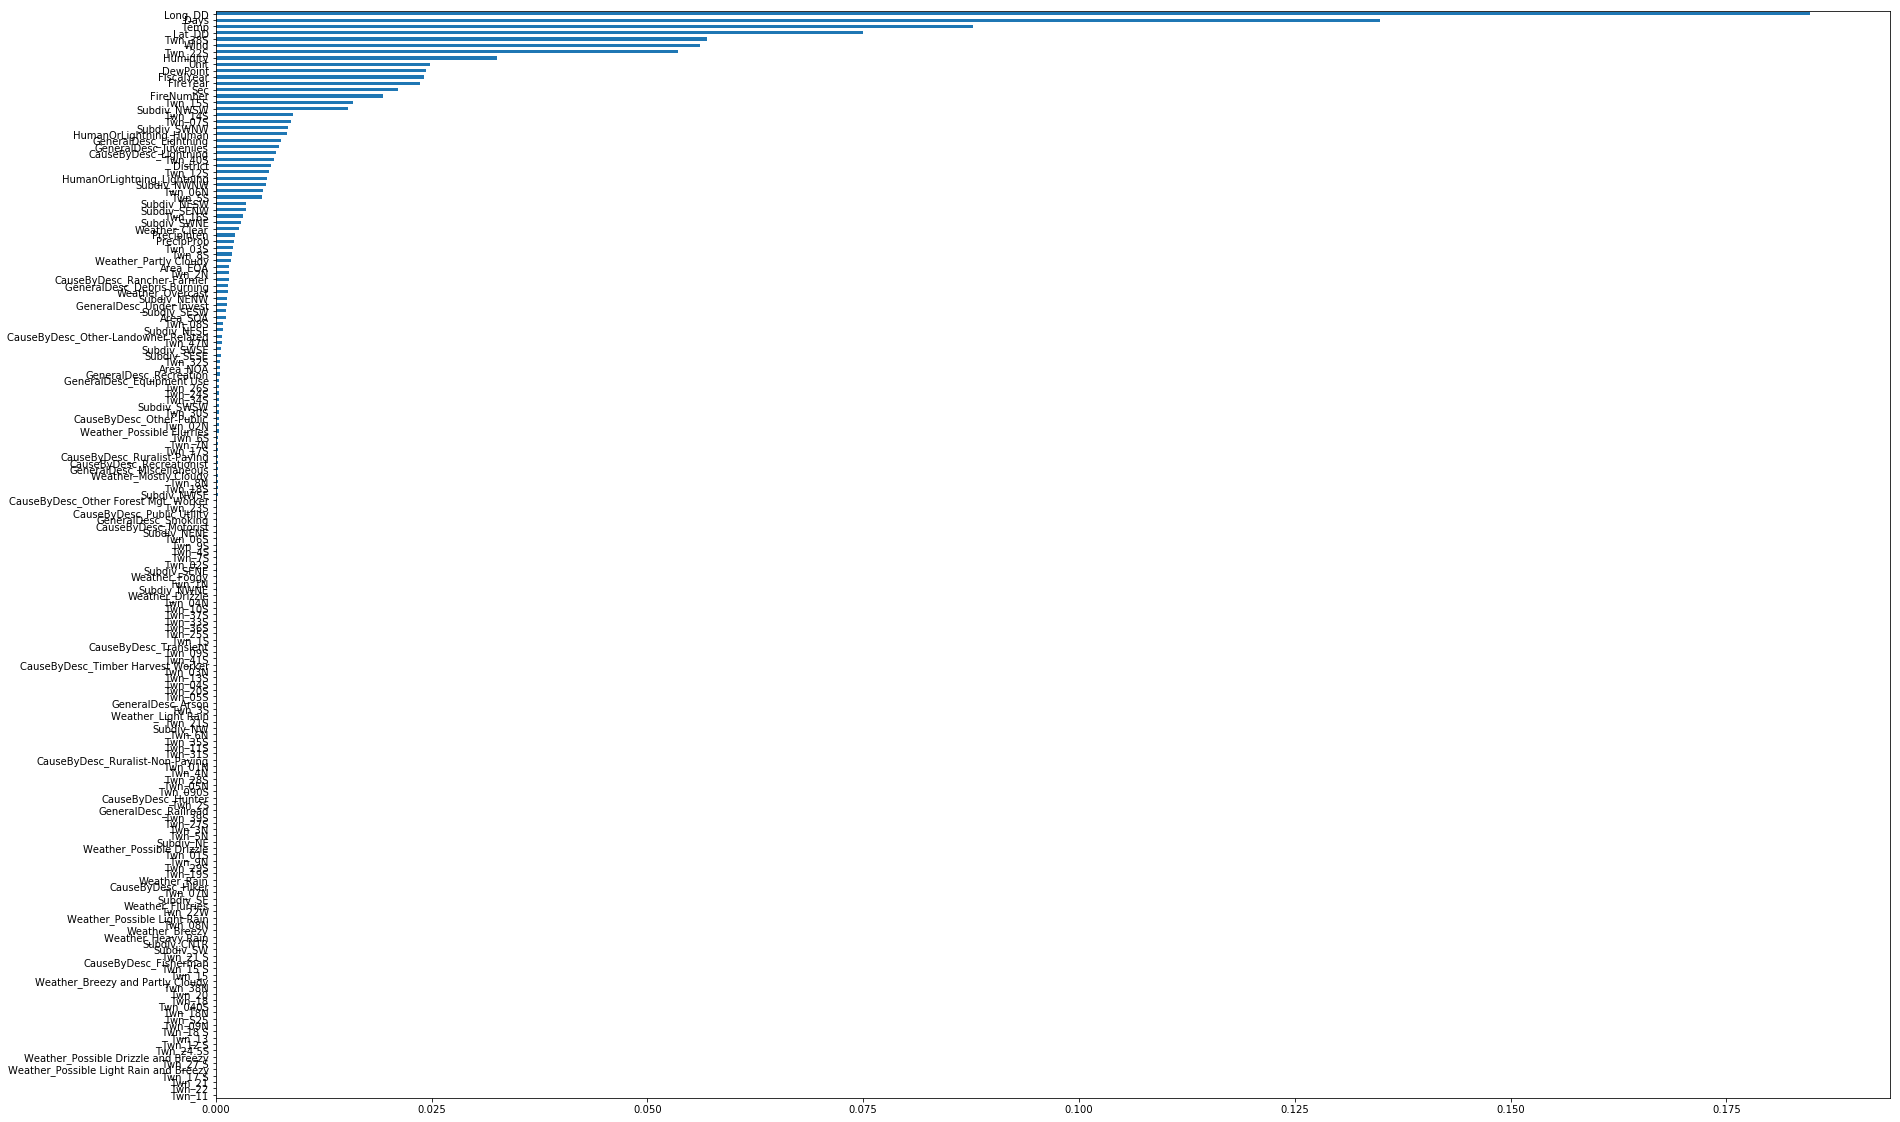

In [52]:
import matplotlib.pyplot as plt
#plotting feature importances
feature_importances = pd.Series(rf1000.feature_importances_, index=feature_list)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh',figsize=(30,20))
plt.show()

In [101]:
len(feature_importances)

172

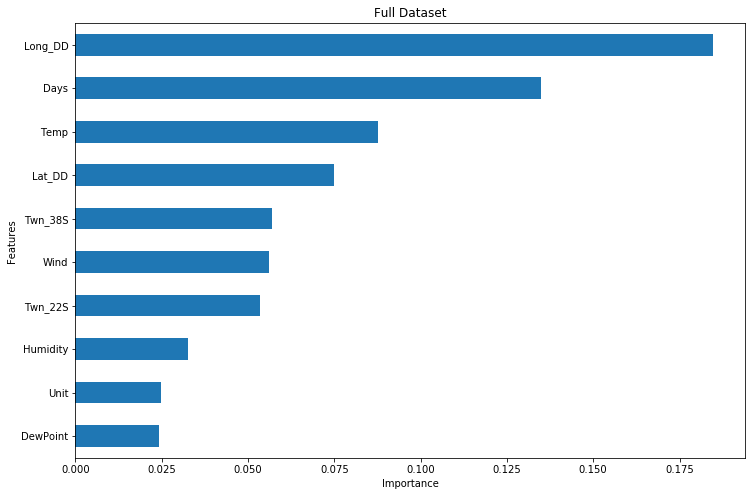

In [105]:
top_10_features = feature_importances[162:]
top_10_features.plot(kind='barh',figsize=(12,8))
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Full Dataset')
plt.show()

In [199]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

#creating SVR 
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

In [204]:
#fit regression model
y_rbf = svr_rbf.fit(train_features_100, train_labels_100.ravel()).predict(test_features_100)
y_lin = svr_lin.fit(train_features_100, train_labels_100.ravel()).predict(test_features_100)
y_poly = svr_poly.fit(train_features_100, train_labels_100.ravel()).predict(test_features_100)

In [207]:
#calculating errors
rbf_error = abs(y_rbf - test_labels_100)
lin_error = abs(y_lin - test_labels_100)
poly_error = abs(y_poly - test_labels_100)

print('Mean Absolute Error for rbf kernel:', round(np.mean(rbf_error), 2), 'degrees.')
print('Mean Absolute Error for lin kernel:', round(np.mean(lin_error), 2), 'degrees.')
print('Mean Absolute Error for poly kernel:', round(np.mean(poly_error), 2), 'degrees.')

Mean Absolute Error for rbf kernel: 2.81 degrees.
Mean Absolute Error for lin kernel: 2169.94 degrees.
Mean Absolute Error for poly kernel: 1097926.5 degrees.


In [209]:
from sklearn.model_selection import cross_val_score
clf = SVR(kernel='rbf', C=1)
scores = cross_val_score(clf, train_features_100, train_labels_100,scoring='accuracy', cv=10)
accuracy = scores.mean()*100
print("Accuracy of SVR is: " , accuracy)

ValueError: continuous is not supported

In [35]:
# loading file from EDA portion where all fires under 100 acres
pickle_in=open('under100.pickle','rb')
dfunder100= pickle.load(pickle_in)

In [55]:
#prepare df for modeling
dfunder100 = dfcleaner(dfunder100)

In [56]:
#preparing data for training on under100 dataset
under_100Model = pd.get_dummies(dfunder100)
target_100 = under_100Model['FireTotalAcres']
features_100 = under_100Model.drop('FireTotalAcres',axis=1)

target_100 = np.array(target_100)
features_100_list = list(features_100.columns)
features_100 = np.array(features_100)

In [57]:
#splitting data for under100 dataset 
train_features_100, test_features_100, train_labels_100, test_labels_100 = train_test_split(features_100,target_100, test_size=0.25,random_state=42)

In [58]:
print('Training Features Shape of under 100:', train_features_100.shape)
print('Training Labels Shape of under 100:', train_labels_100.shape)
print('Testing Features Shape of under 100:', test_features_100.shape)
print('Testing Labels Shape of under 100:', test_labels_100.shape)

Training Features Shape of under 100: (9308, 170)
Training Labels Shape of under 100: (9308,)
Testing Features Shape of under 100: (3103, 170)
Testing Labels Shape of under 100: (3103,)


In [59]:
# Instantiate model with 1000 decision trees
rf_small = RandomForestRegressor(n_estimators = 1000, oob_score = True, random_state = 42)

# Train the model on training data
rf_small.fit(train_features_100, train_labels_100.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [60]:
# Use the forest's predict method on the test data under 100 acres
predictions_small = rf_small.predict(test_features_100)

# Calculate the absolute errors
errors_small = abs(predictions_small - test_labels_100)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_small), 2), 'degrees.')

Mean Absolute Error: 2.56 degrees.


In [61]:
print('R^2 score is', round(rf_small.oob_score_, 6))

R^2 score is 0.057238


Mean absolute error is down significantly, but the R^2 still appears to be weak.

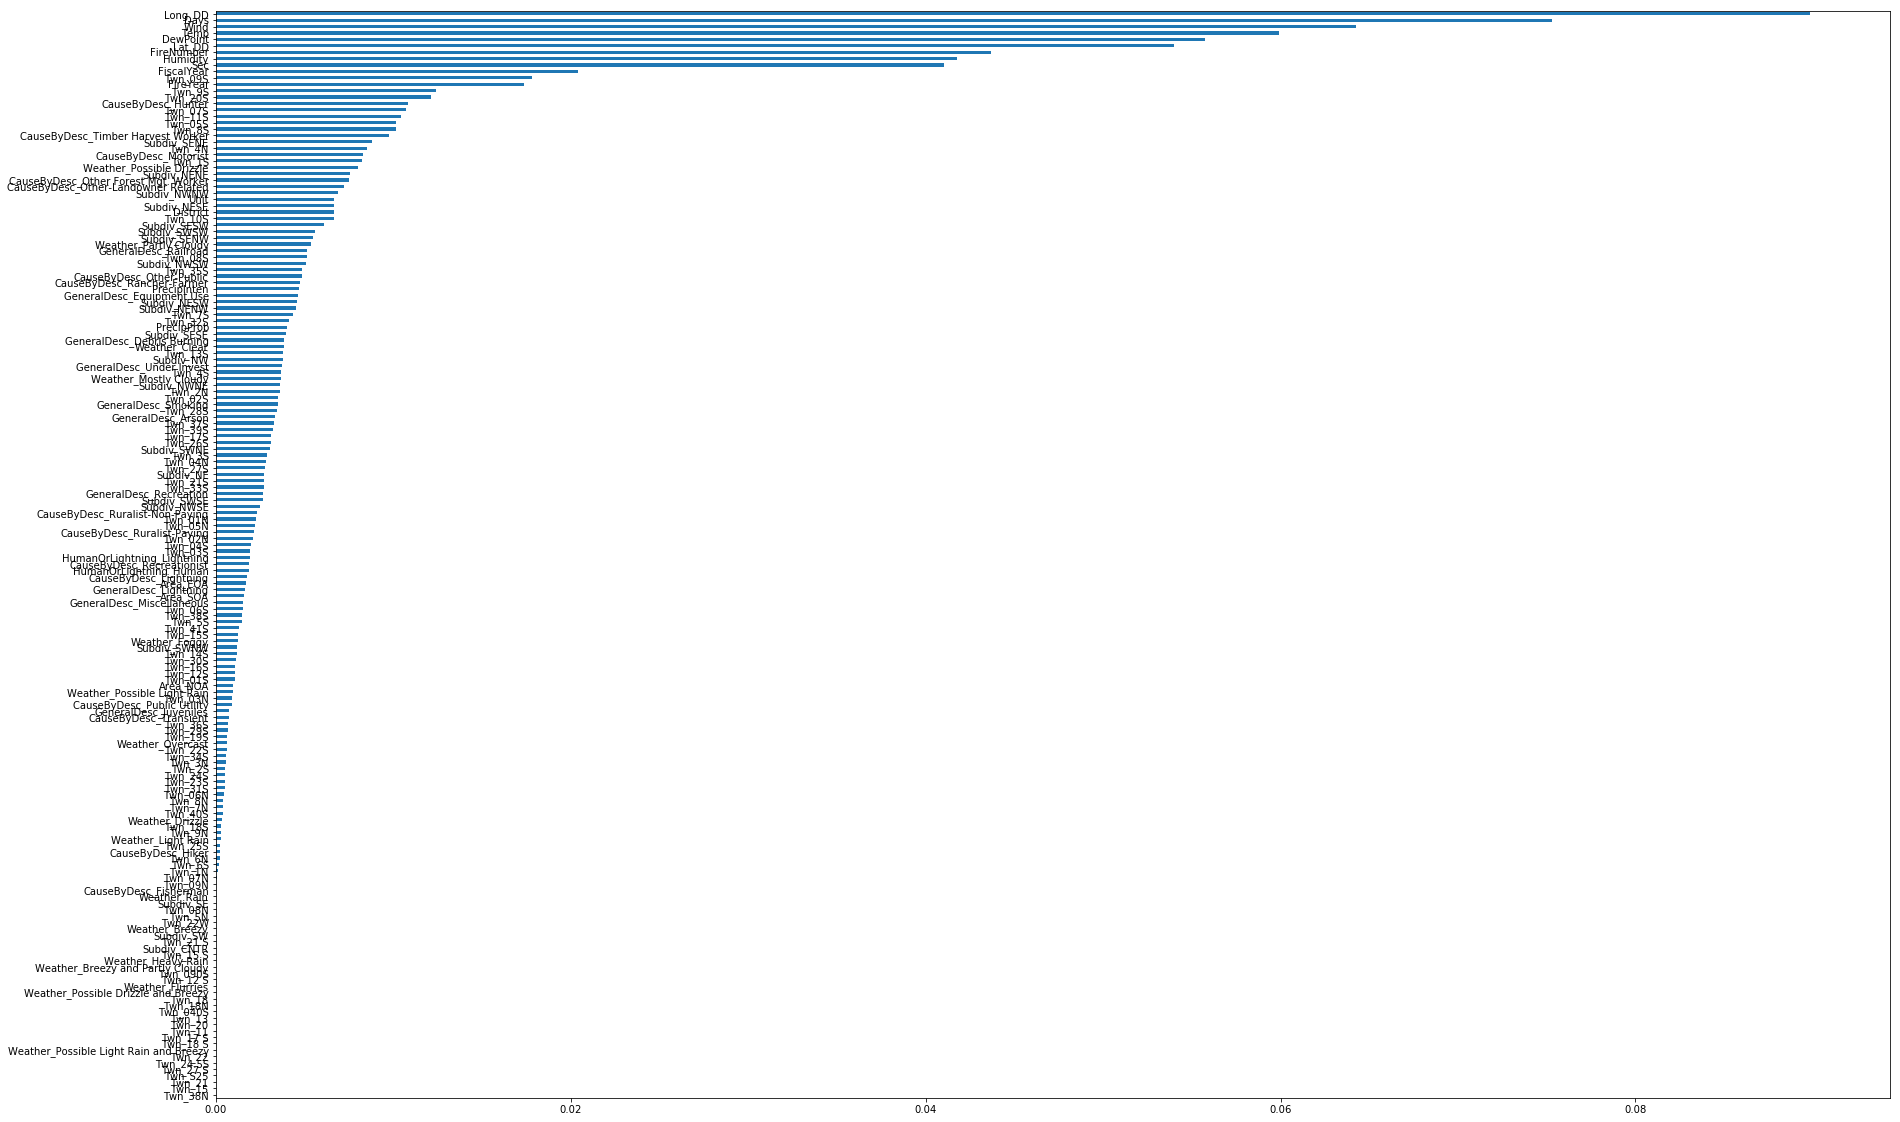

In [62]:
#plotting feature importances
small_importance = pd.Series(rf_small.feature_importances_, index=features_100_list)
small_importance.sort_values(inplace=True)
small_importance.plot(kind='barh',figsize=(30,20))
plt.show()

Let's try and decrease the amount of features to feed the model.  Looking at the feature importance it appears that there is a sharp drop off of the first 13 features.

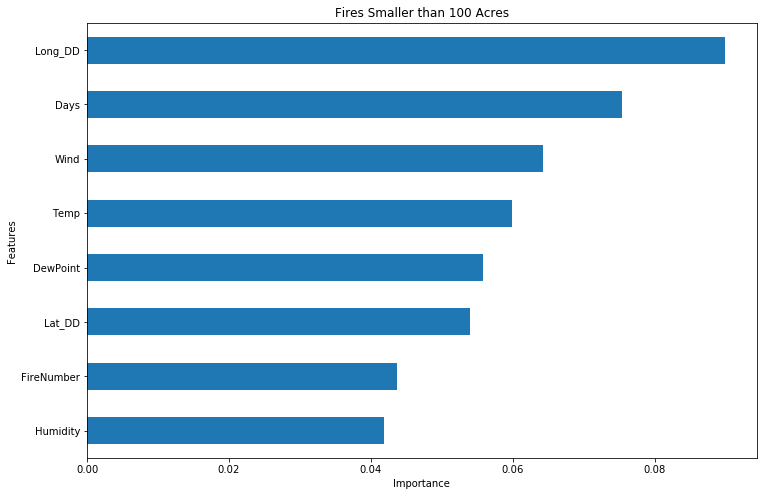

In [107]:
#top 10 features
top_10_small = small_importance[162:]
top_10_small.plot(kind='barh',figsize=(12,8))
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Fires Smaller than 100 Acres')
plt.show()

In [65]:
small_importance.tail(13)

Twn_9S        0.012384
FireYear      0.017386
Twn_09S       0.017803
FiscalYear    0.020410
Sec           0.041019
Humidity      0.041776
FireNumber    0.043709
Lat_DD        0.053983
DewPoint      0.055734
Temp          0.059928
Wind          0.064269
Days          0.075297
Long_DD       0.089843
dtype: float64

In [66]:
#creating a function to clean dataframes only feeding the top features
def dfcleaner2(df):
    df = df[['FireYear','Unit','Sec','Long_DD','Lat_DD','FireTotalAcres','Temp','DewPoint','Humidity','Wind','Days']]
    return df

In [68]:
dfslim = dfcleaner(dfunder100)

In [70]:
#preparing data for training on df under 100 acres with only top features
modelb = pd.get_dummies(dfslim)
target_b = modelb['FireTotalAcres']
features_b = modelb.drop('FireTotalAcres',axis=1)

target_b = np.array(target_b)
features_b_list = list(features_b.columns)
features_b = np.array(features_b)

In [72]:
#splitting for training and testing set
train_features_b, test_features_b, train_labels_b, test_labels_b = train_test_split(features_b,target_b, test_size=0.25,random_state=42)

In [73]:
# model b
print('Training Features Shape of model b:', train_features_b.shape)
print('Training Labels Shape of model b:', train_labels_b.shape)
print('Testing Features Shape of model b:', test_features_b.shape)
print('Testing Labels Shape of model b:', test_labels_b.shape)

Training Features Shape of model b: (9308, 170)
Training Labels Shape of model b: (9308,)
Testing Features Shape of model b: (3103, 170)
Testing Labels Shape of model b: (3103,)


In [74]:
# Instantiate model with 1000 decision trees
rfb = RandomForestRegressor(n_estimators = 1000, oob_score = True, random_state = 42)

# Train the model on training data
rfb.fit(train_features_b, train_labels_b.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [75]:
predictions_b = rfb.predict(test_features_b)

# Calculate the absolute errors
errors_b = abs(predictions_b - test_labels_b)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_b), 2), 'degrees.')

Mean Absolute Error: 2.56 degrees.


In [76]:
print('R^2 score is', round(rfb.oob_score_, 6))

R^2 score is 0.057238


Identical performance based on only those features.  Next we will try a SVR model.  

In [77]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

#creating SVR 
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

In [78]:
#fit regression model
y_rbf = svr_rbf.fit(train_features_100, train_labels_100.ravel()).predict(test_features_100)
y_lin = svr_lin.fit(train_features_100, train_labels_100.ravel()).predict(test_features_100)
y_poly = svr_poly.fit(train_features_100, train_labels_100.ravel()).predict(test_features_100)

In [79]:
#calculating errors
rbf_error = abs(y_rbf - test_labels_100)
lin_error = abs(y_lin - test_labels_100)
poly_error = abs(y_poly - test_labels_100)

print('Mean Absolute Error for rbf kernel:', round(np.mean(rbf_error), 2), 'degrees.')
print('Mean Absolute Error for lin kernel:', round(np.mean(lin_error), 2), 'degrees.')
print('Mean Absolute Error for poly kernel:', round(np.mean(poly_error), 2), 'degrees.')

Mean Absolute Error for rbf kernel: 2.76 degrees.
Mean Absolute Error for lin kernel: 1802.66 degrees.
Mean Absolute Error for poly kernel: 1030680.11 degrees.


In [80]:
from sklearn.model_selection import cross_val_score
clf = SVR(kernel='rbf', C=1)
scores = cross_val_score(clf, train_features_100, train_labels_100, cv=10)
accuracy = scores.mean()*100


In [81]:
accuracy

-3.089256468859225